Import packages

In [4]:
from utils import *
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, BatchNormalization, MaxPooling2D, Reshape, LSTM, TimeDistributed, Permute
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
import datetime

Load dataset

In [5]:
X_train, y_train, X_test, y_test = init_data(subject=None, verbose=True)
X_train_aug, y_train_aug, X_test_aug, y_test_aug, X_valid_aug, y_valid_aug= preprocess_data(X_train, y_train, X_test, y_test, verbose=True)
x_train_aug, y_train_aug, x_valid_aug, y_valid_aug, x_test_aug, y_test_aug = load_data(X_train_aug, y_train_aug, X_valid_aug, y_valid_aug, X_test_aug, y_test_aug, verbose=True)

Training data shape: (7616, 22, 400) Training target shape: (7616,)
Testing data shape: (443, 22, 400) Testing target shape: (443,)
Training data shape: (7616, 400, 1, 22) Training target shape: (7616, 4)
Validation data shape: (844, 400, 1, 22) Validation target shape: (844, 4)
Testing data shape: (443, 400, 1, 22) Testing target shape: (443, 4)


Initial model structure

In [6]:
# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(15,1), padding='same', activation='elu', input_shape=(400,1,22)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(15,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(15,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# # Conv. block 4
# hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(15,1), padding='same', activation='elu'))
# hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
# hybrid_cnn_lstm_model.add(BatchNormalization())
# hybrid_cnn_lstm_model.add(Dropout(0.5))

# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(Dense((40))) # FC layer with 100 units
hybrid_cnn_lstm_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible
# hybrid_cnn_lstm_model.add(LSTM(10, dropout=0.5, recurrent_dropout=0.1, return_sequences=True))

hybrid_cnn_lstm_model.add(LSTM(10, dropout=0.5, recurrent_dropout=0.1))
# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_lstm_model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 400, 1, 25)        8275      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 134, 1, 25)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 134, 1, 25)       100       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 134, 1, 25)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 134, 1, 50)        18800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 1, 50)        0

In [7]:
%load_ext tensorboard

In [17]:
!rm -rf ./logs/

In [18]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 52177), started 0:12:04 ago. (Use '!kill 52177' to kill it.)

In [19]:
# !kill 33800

In [24]:
# Model parameters
learning_rate = 1e-5
epochs = 20
hybrid_cnn_lstm_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# create a tensorboard callback to visualize training
tb_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)

# anneals the learning rate
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.1)  # reduces by a factor of 10 if validation loss doesn't improve for 10 epochs

# checkpoint saving callback
save_cb = tf.keras.callbacks.ModelCheckpoint(
    'models/checkpoint_{epoch:02d}_{val_loss:0.2f}',   # where to save models
    monitor= 'val_loss',
    verbose = 0,
    save_best_only = False,
    save_weights_only = False,
    save_freq='epoch'   # saves every epoch
)

Compile and train the model

In [25]:
# Compiling the model
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'],
                )

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train_aug,
             y_train_aug,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid_aug, y_valid_aug), verbose=True,
             callbacks=[tb_callback]
             )


Epoch 1/20
119/119 [==============================] - 11s 77ms/step - loss: 0.3155 - accuracy: 0.8852 - val_loss: 0.6123 - val_accuracy: 0.7737
Epoch 2/20
119/119 [==============================] - 10s 80ms/step - loss: 0.3179 - accuracy: 0.8866 - val_loss: 0.6064 - val_accuracy: 0.7832
Epoch 3/20
119/119 [==============================] - 9s 72ms/step - loss: 0.2989 - accuracy: 0.8921 - val_loss: 0.6015 - val_accuracy: 0.7796
Epoch 4/20
119/119 [==============================] - 9s 73ms/step - loss: 0.3035 - accuracy: 0.8910 - val_loss: 0.6006 - val_accuracy: 0.7725
Epoch 5/20
119/119 [==============================] - 10s 82ms/step - loss: 0.3047 - accuracy: 0.8880 - val_loss: 0.6135 - val_accuracy: 0.7725
Epoch 6/20
119/119 [==============================] - 9s 75ms/step - loss: 0.2927 - accuracy: 0.8917 - val_loss: 0.6182 - val_accuracy: 0.7725
Epoch 7/20
119/119 [==============================] - 9s 74ms/step - loss: 0.3058 - accuracy: 0.8868 - val_loss: 0.6116 - val_accuracy: 0.7

KeyboardInterrupt: 

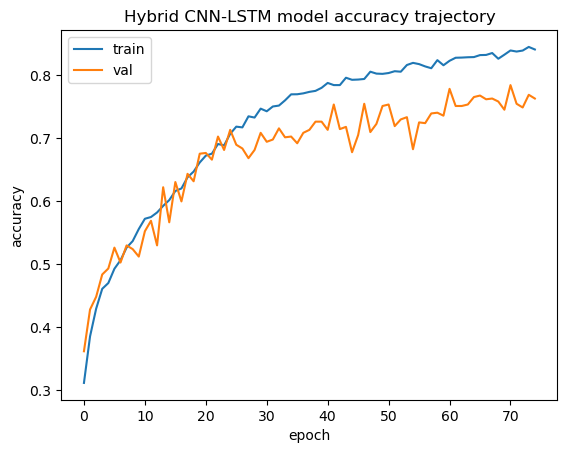

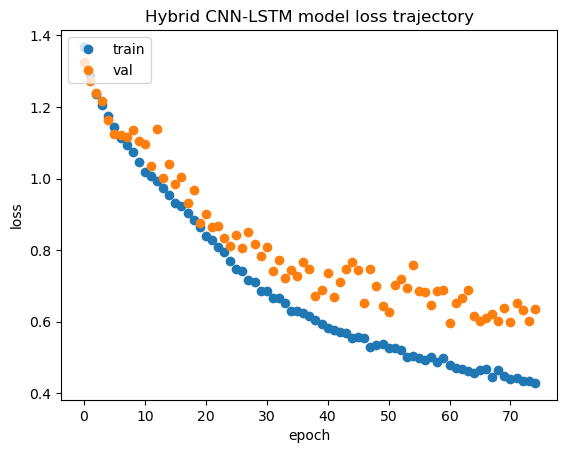

In [22]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test_aug, y_test_aug, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.747178316116333
